[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AkhilMunjaal/explainable-ai/blob/main/SHAP_xai.ipynb)



In [ ]:
!pip install datasets
!pip install transformers
!pip install torch
!pip install shap

## What is SHAP ?

---

SHAP (SHapley Additive exPlanations) is a game-theoretic approach to explain the output of any machine learning model. It helps us interpret machine learning models with Shapely values.

### What is Shapley Values ?

---

Given a prediction, how do we most accurately measure each feature’s contribution.

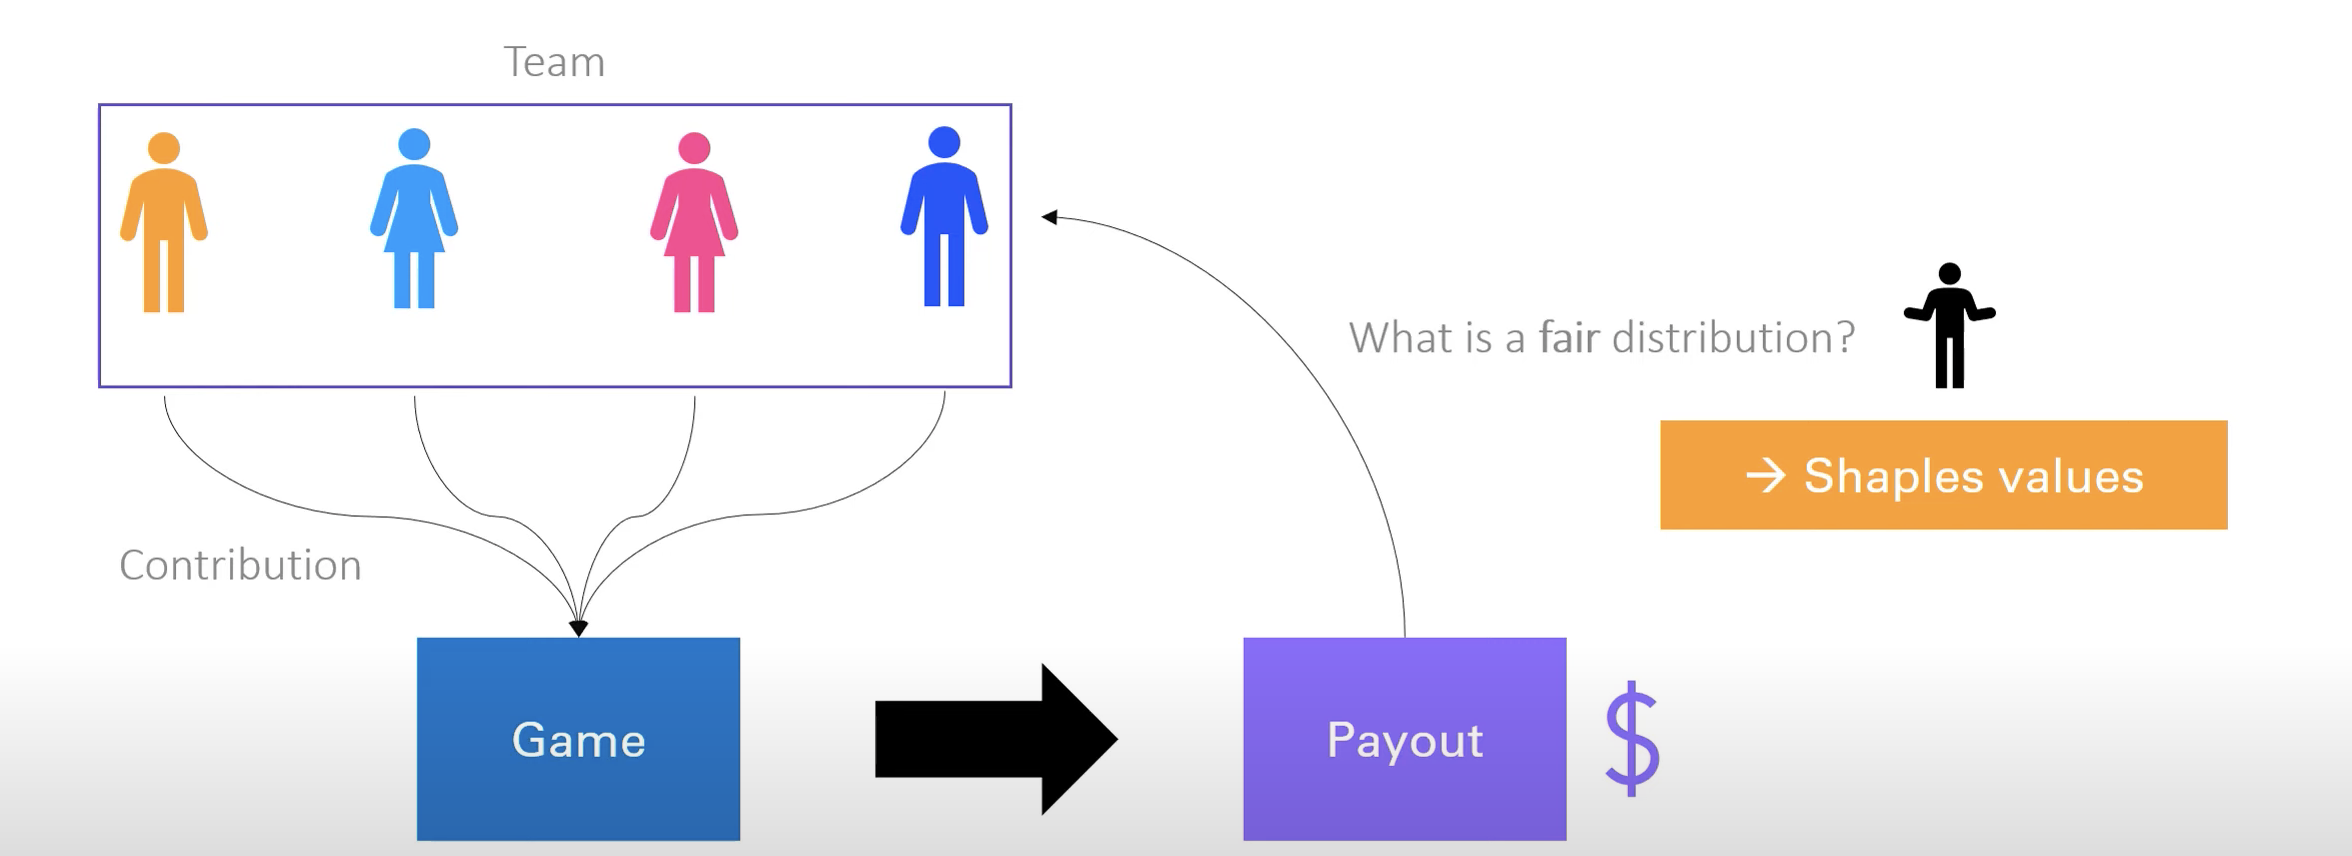

< add some explanation >

Natural Language Processing - Partition SHAP   

---

If we look at the formal definition of shapley, we can see that as the number of features increases, it becomes computationally intractable (2^n). For natural language processing tasks, where features can be huge (768 for bert) it by default computes the Owen value, which is a computationally tractable approximation of the Shapley values.

In [2]:
import torch
import transformers
import datasets
import shap
import pandas as pd

In [3]:
dataset  = datasets.load_dataset("emotion", split = "train")
data = pd.DataFrame({'text':dataset['text'],'emotion':dataset['label']})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


In [4]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
# load the model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("nateraw/bert-base-uncased-emotion", use_fast=True)
model = transformers.AutoModelForSequenceClassification.from_pretrained("nateraw/bert-base-uncased-emotion").cuda()

In [6]:
# build a pipeline object to do predictions
pred = transformers.pipeline("text-classification", model=model, tokenizer=tokenizer, device=0, return_all_scores=True)

`return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.


### shap.Explainer 

---

A transformers pipeline object can be passed directly to shap.Explainer, which will then wrap the pipeline model as a shap.models.TransformersPipeline model (By default transformers pipeline object output lists of dictionaries, not standard tensors as expected by SHAP. This class wraps pipelines to make them output nice tensor formats) and the pipeline tokenizer as a shap.maskers.Text masker.

In [16]:
explainer = shap.Explainer(pred)

In [22]:
# calculate shap values for first 25 records - it takes time to evaluate shapley values, keeping it short for demo
shap_values = explainer(data['text'][:25])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/462 [00:00<?, ?it/s]

Partition explainer:  36%|███▌      | 9/25 [00:27<00:45,  2.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 15/25 [00:40<00:18,  1.90s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  96%|█████████▌| 24/25 [01:04<00:02,  2.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 26it [01:14,  3.38s/it]


Let's look at few examples of what the model predicts and how does SHAP tries to explain the prediction

Example 1 :

In [31]:
data['text'][8], pred(data['text'][8])

('i have been with petronas for years i feel that petronas has performed well and made a huge profit',
 [[{'label': 'sadness', 'score': 0.000577050494030118},
   {'label': 'joy', 'score': 0.996459424495697},
   {'label': 'love', 'score': 0.0013418151065707207},
   {'label': 'anger', 'score': 0.0005132677615620196},
   {'label': 'fear', 'score': 0.0003893037501256913},
   {'label': 'surprise', 'score': 0.0007190926116891205}]])

In [23]:
shap.plots.text(shap_values[8:9])

In [53]:
# what if we change the input text, how does the model and explainer perform ?
print('Model Prediction: \n',pred('i have been with petronas for years, yet i have no idea on petronas performance'))
shap.plots.text(explainer(['i have been with petronas for years, yet i have no idea on petronas performance']))


Model Prediction: 
 [[{'label': 'sadness', 'score': 0.055501244962215424}, {'label': 'joy', 'score': 0.41259586811065674}, {'label': 'love', 'score': 0.012079921551048756}, {'label': 'anger', 'score': 0.35702279210090637}, {'label': 'fear', 'score': 0.15089668333530426}, {'label': 'surprise', 'score': 0.01190355233848095}]]


Example 2 :

In [54]:
data['text'][1], pred(data['text'][1])


('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 [[{'label': 'sadness', 'score': 0.9952924251556396},
   {'label': 'joy', 'score': 0.0011914707720279694},
   {'label': 'love', 'score': 0.0009963022312149405},
   {'label': 'anger', 'score': 0.00046281967661343515},
   {'label': 'fear', 'score': 0.0016494384035468102},
   {'label': 'surprise', 'score': 0.00040760444244369864}]])

In [55]:
shap.plots.text(explainer(data['text'][1:2]))

  0%|          | 0/498 [00:00<?, ?it/s]

### Words impacting a specific class

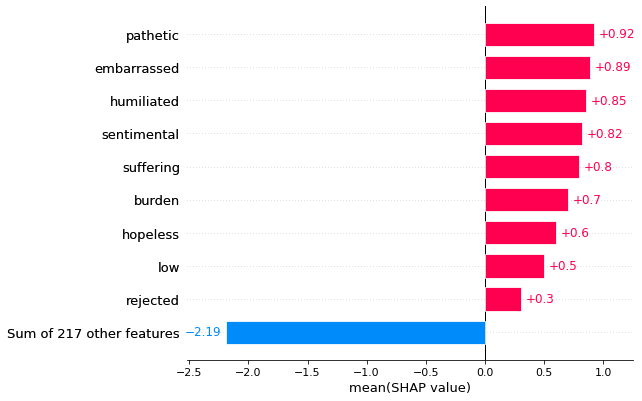

In [58]:
shap.plots.bar(shap_values[:,:,"sadness"].mean(0), order=shap.Explanation.argsort.flip)